### Check if can access data from the notebook

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
%ls "/content/drive/My Drive/data/images"

test/  train/


# Imports

In [9]:
from google.colab import files
import os
import time
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torch.autograd import Variable
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## GPU Usage

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data loading & analysis

This first part of the notebook have the following purposes:
- Load train folder
- Implement a reusable method to get DataLoaders splitted by train and validation.
- Analyze train data
  - Size of train folder
  - Randomly get a set of images and display them (with associated target)
  - Extract observations from images
  - Count images for each target class

Before working on the modeling, it is very important to really understand the data we are working with. If we do not analyze data and pre-process it correctly, final accuracy will likely be lower than it could be.

### Load images

In [13]:
# Load images from train folder
transf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])
train_dataset_path = "/content/drive/My Drive/data/images/train"
train_dataset = ImageFolder(train_dataset_path, transform=transf)
print(f"Full train dataset size: {len(train_dataset)}")

Full train dataset size: 9081


In [21]:
# Count images for each target class
TARGET_CLASSES = train_dataset.classes

print("Count images for each target class in train dataset: \n")
for target_class in TARGET_CLASSES:
    class_count = len(os.listdir(os.path.join(train_dataset_path, target_class)))
    print(f"{target_class}: {class_count} images")

Count images for each target class in train dataset: 

FIVE: 1510 images
FOUR: 1526 images
NONE: 1509 images
ONE: 1510 images
THREE: 1511 images
TWO: 1515 images


In [53]:
TARGET_CLASSES

['FIVE', 'FOUR', 'NONE', 'ONE', 'THREE', 'TWO']

The quantity of images per target class is pretty well balanced. A good strategy when dataset is very unbalanced is to generate images for that specific classes with low amount of data.

In the following 2 cells I will create a DataLoader with 32 random examples (minibatch example).
The purpose of this is to randomly select some examples and print the size of the images to have an idea of the images dimension.

In [22]:
BATCH_SIZE = 32

In [23]:
# This function splits batch items into 2 lists [[image], [target]]
def collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    target = torch.LongTensor(target)
    return [data, target]

train_transform = transforms.Compose([
    transforms.ToTensor()
])

example_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate, shuffle=True)
examples = enumerate(example_loader)

batch_idx, (example_data, example_targets) = next(examples)

for i in range(BATCH_SIZE):
  print(f"Image dimensions {example_data[i].shape}")

Image dimensions torch.Size([3, 300, 300])
Image dimensions torch.Size([3, 300, 300])
Image dimensions torch.Size([3, 300, 300])
Image dimensions torch.Size([3, 300, 300])
Image dimensions torch.Size([3, 300, 300])
Image dimensions torch.Size([3, 300, 300])
Image dimensions torch.Size([3, 300, 300])
Image dimensions torch.Size([3, 300, 300])
Image dimensions torch.Size([3, 300, 300])
Image dimensions torch.Size([3, 300, 300])
Image dimensions torch.Size([3, 300, 300])
Image dimensions torch.Size([3, 300, 300])
Image dimensions torch.Size([3, 300, 300])
Image dimensions torch.Size([3, 300, 300])
Image dimensions torch.Size([3, 300, 300])
Image dimensions torch.Size([3, 300, 300])
Image dimensions torch.Size([3, 300, 300])
Image dimensions torch.Size([3, 300, 300])
Image dimensions torch.Size([3, 300, 300])
Image dimensions torch.Size([3, 300, 300])
Image dimensions torch.Size([3, 300, 300])
Image dimensions torch.Size([3, 300, 300])
Image dimensions torch.Size([3, 300, 300])
Image dimen

As we can see, dimension of the images is constant. 


### Images visualization (mini-batch)

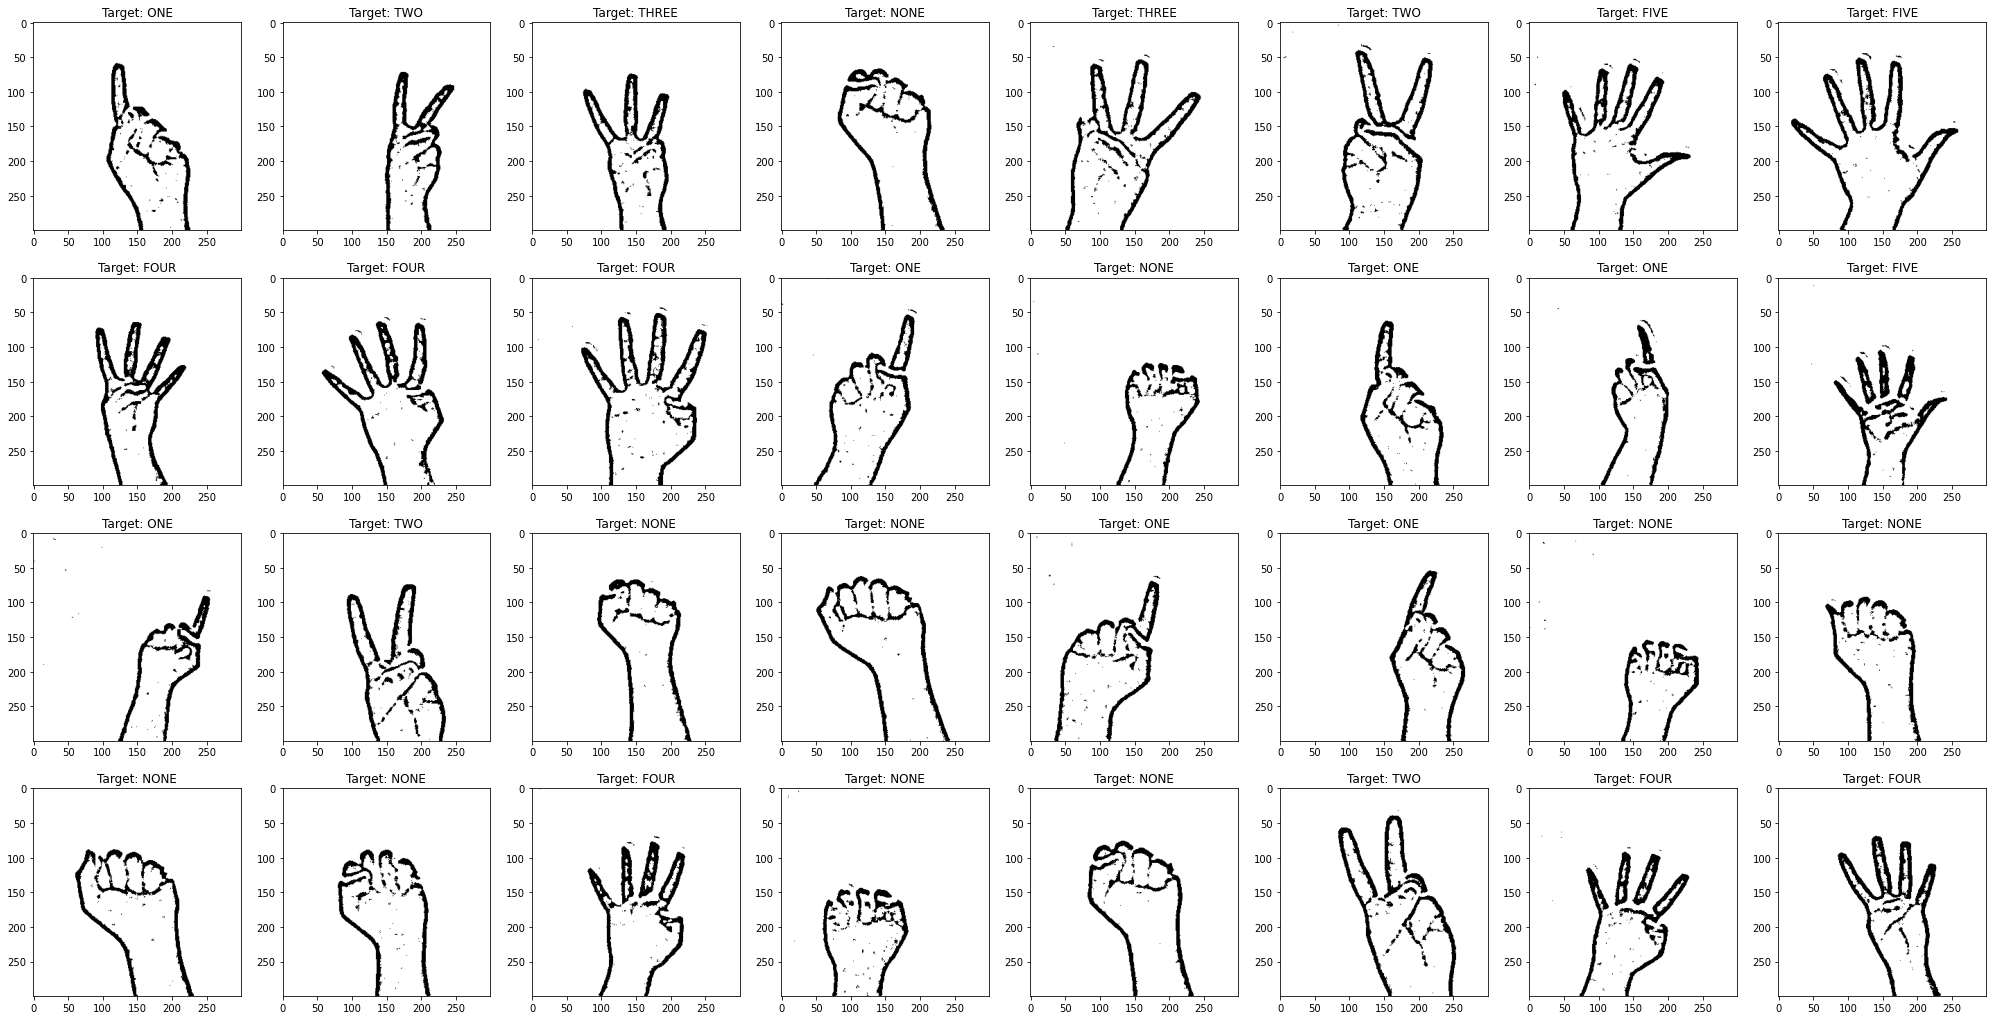

In [24]:
fig = plt.figure(figsize=(35, 18))
for i in range(BATCH_SIZE):
  image = example_data[i]
  image = image.numpy().transpose((1, 2, 0))
  image = np.clip(image, 0, 1)
  plt.subplot(4, 8, i+1)
  plt.imshow(image)
  plt.title(f"Target: {TARGET_CLASSES[example_targets[i]]}")
  

## Image Augmentation

Taking images observations into account, I will present Image Augmentation strategy to train the classifier. This technique will be used to favor generalization of the model (reduce overfitting by applying regularization technique). Basically I will apply certain transformations to the images while training in order to learn features from images with different color, brightness, rotations, etc.

Considering the images for this problem I will use the following transformations:

*   RandomHorizontalFlip & RandomVerticalFlip - With a probability of 50% flip the image horizontally & vertically. As the photos where taken from above the plants, is reasonable to flip them both horizontally or vertically. There are some cases where this does not apply, for example if we are classifying landscapes images, is reasonable to flip horizontally but not vertically, since is not real to have the sky and the sun bellow the mountains and trees.
*   ColorJitter - As many images are blurry and poor lighting, I will randomly apply changes to color, saturation and brightness of the image.
*   RandomErasing - This transform removes a small rectangle of the image. Randomly erasing sections of the image improves generalization by avoiding to remember specific images characteristics.

## DataLoader generator

The following function creates a dataloader for train & validation.
Instead of repeating code along the notebook I prefer defining a generic and reusable method to abstract the responsability of building a DataLoader.

**Input**: train_transforms, batch_size

**Output**: train_DataLoader, validation_DataLoader

I will use 20% of train dataset for validation.

In [27]:
def get_dataloaders(train_transf, batch_size):
  train_dataset = ImageFolder("/content/drive/My Drive/data/images/train", transform=train_transf)

  # Split train & validation
  train_size = int(0.8 * len(train_dataset))
  valid_size = len(train_dataset) - train_size
  train, validation = random_split(train_dataset, [train_size, valid_size])
  print(f"{len(train)} Training images, {len(validation)} Validation images")

  train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2)
  valid_loader = DataLoader(validation, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2)

  return train_loader, valid_loader

# Train and validate methods

Before moving to the model implementation, I will define train and validate methods.

Train method will be responsible of iterating through epochs in order to run the model for predictions, calculate the loss and run backprop to update model (net) weights.

Validate method will be used for validation set. For this one the model will be switched to validation state just to predict and calculate the loss (no backprop present in this phase).





## How will I measure model performance?

It is very important to define metrics to track model performance along the time. The main metric I will use to track performance will be **F1 Score** since is the metric used by Kaggle competition to evaluate predictions. In addition I will also present other metrics such as: **Accuracy**, **Precission** & **Recall**

In [44]:
# Input:
#        - training_model: neural net to train.
#        - loader: DataLoader with training data.
#        - criterion: loss function.
#        - optim: optimizer in charge of updating model parameters based on computed gradients.
# Output:
#        - average loss of the epoch
#        - % of accuracy score
#        - % of precission score
#        - % of recall score
#        - % of F1 score
#
# Apart from metrics, for each training epoch I will track cumulative loss in order to plot loss evolution
def train_epoch(training_model, loader, criterion, optim):
    # set model to train state
    training_model.train()
    
    epoch_loss = 0.0
    
    # save 'y' and 'y_hat' for each image prediction
    all_labels = []
    all_predictions = []

    for images, labels in loader:
        # add mini-batch targets (tensor to list) to the end of 'all_labels' list
        all_labels.extend(labels.numpy())

        # reset gradients
        optim.zero_grad()

        # predict and save result to 'all_predictions' list
        # mini-batch images are mounted to the GPU
        predictions = training_model(images.to(device))

        # using cpu to get the class with highest value returned by the net
        all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())

        # mount labels to GPU and calculate loss comparing them with model predictions
        loss = criterion(predictions, labels.to(device))
        loss.backward()

        # Backprop, compute gradients and update model parameters
        optim.step()

        epoch_loss += loss.item()
    

    return epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100, precision_score(all_labels, all_predictions, average="weighted") * 100, recall_score(all_labels, all_predictions, average="weighted") * 100 , f1_score(all_labels, all_predictions, average="weighted") * 100


In [45]:
# Input:
#        - val_model: neural net to validate.
#        - loader: DataLoader with validation data.
#        - criterion: loss function.
# Output:
#        - average loss of the validation epoch
#        - % of accuracy score
#        - % of precission score
#        - % of recall score
#        - % of F1 score
def validation_epoch(val_model, loader, criterion):
    # set model to test state
    val_model.eval()
  
    epoch_loss = 0.0
    all_labels = []
    all_predictions = []
    with torch.no_grad(): # temporarily set all the requires_grad flag to false
      for images, labels in loader:
          all_labels.extend(labels.numpy())
    
          predictions = val_model(images.to(device))
          all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())
    
          loss = criterion(predictions, labels.to(device))
    
          epoch_loss += loss.item()
    return epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100, precision_score(all_labels, all_predictions, average="weighted") * 100, recall_score(all_labels, all_predictions, average="weighted") * 100 , f1_score(all_labels, all_predictions, average="weighted") * 100


In [46]:
# Input:
#        - model: neural net to train.
#        - train_loader: DataLoader with train data.
#        - validation_loader: DataLoader with validation data.
#        - criterion: loss function.
#        - optim: optimizer in charge of updating model parameters based on computed gradients.
# Output:
#        - train_history: list with the average loss of each training epoch
#        - validation_history: list with the average loss of each validation epoch
def train_model(model, train_loader, validation_loader, criterion, optim, number_epochs):
  train_history = []
  validation_history = []

  for epoch in range(number_epochs):
      # track time for each epoch
      start_time = time.time()

      # Training epoch
      train_loss, train_acc, train_prec, train_recall, train_f1 = train_epoch(model, train_loader, criterion, optimizer)
      train_history.append(train_loss)
      print("Training epoch {} | Loss {:.6f} | Accuracy {:.2f}% | F1 {:.2f}% | Precision {:.2f}% | Recall {:.2f}% | Time {:.2f} seconds"
            .format(epoch + 1, train_loss, train_acc, train_f1, train_prec, train_recall, time.time() - start_time))

      # Validation epoch
      start_time = time.time()
      valid_loss, valid_acc, valid_prec, valid_recall, valid_f1 = validation_epoch(model, validation_loader, criterion)
      validation_history.append(valid_loss)
      print("Validation epoch {} | Loss {:.6f} | Accuracy {:.2f}% | F1 {:.2f}% | Precision {:.2f}% | Recall {:.2f}% | Time {:.2f} seconds"
            .format(epoch + 1, valid_loss, valid_acc, valid_f1, valid_prec, valid_recall, time.time() - start_time))

  return train_history, validation_history

# Model definition & training

How does a neural network learn image features? This a good question and generally this architectures learn more complex features of the image while moving forward in the layers.

So, the first layers of the net learn simple features such as horizontal lines, vertical lines, circles and generalized shapes. Going deeper in the network, the model learns more complex things directly associated with the problem itself.

I will use Pretrained [PyTorch ResNet](https://pytorch.org/hub/pytorch_vision_resnet/) implementation. I think trying with transfer learning is a good option for this problem. This model comes with pretrained weights out of the box (trained with imagenet) that could save time of training and produce very good results.

In [47]:
class TorchVisionResNet18(nn.Module):
  def __init__(self):
    super(TorchVisionResNet18, self).__init__()
    # self.net = models.resnet18(weights="IMAGENET1K_V1")
    self.net = models.resnet18(weights=None)
    num_features = self.net.fc.in_features
    self.net.fc = nn.Linear(num_features, len(TARGET_CLASSES))
  
  def forward(self, x):
    return self.net(x)

#### Without Image Augmentation

In [55]:
# Set seed for repetibility
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

LR = 0.000001
NUMBER_EPOCHS = 10

# Define train transform
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])

train_loader, valid_loader = get_dataloaders(train_transform, BATCH_SIZE)

resnet18 = TorchVisionResNet18().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(resnet18.parameters(), lr=LR)

train_loss, valid_loss = train_model(resnet18, train_loader, valid_loader, criterion, optimizer, NUMBER_EPOCHS)

7264 Training images, 1817 Validation images
Training epoch 1 | Loss 1.810917 | Accuracy 22.40% | F1 11.08% | Precision 8.59% | Recall 22.40% | Time 31.53 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation epoch 1 | Loss 1.709271 | Accuracy 28.84% | F1 14.57% | Precision 20.62% | Recall 28.84% | Time 6.34 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training epoch 2 | Loss 1.620980 | Accuracy 31.31% | F1 18.80% | Precision 32.20% | Recall 31.31% | Time 31.27 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation epoch 2 | Loss 1.538870 | Accuracy 35.06% | F1 23.57% | Precision 48.11% | Recall 35.06% | Time 6.26 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training epoch 3 | Loss 1.457070 | Accuracy 43.19% | F1 34.27% | Precision 45.19% | Recall 43.19% | Time 30.21 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation epoch 3 | Loss 1.380306 | Accuracy 50.52% | F1 44.16% | Precision 47.08% | Recall 50.52% | Time 6.30 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training epoch 4 | Loss 1.310163 | Accuracy 55.69% | F1 50.15% | Precision 64.68% | Recall 55.69% | Time 30.75 seconds
Validation epoch 4 | Loss 1.246787 | Accuracy 57.46% | F1 52.10% | Precision 65.22% | Recall 57.46% | Time 6.30 seconds
Training epoch 5 | Loss 1.186100 | Accuracy 62.39% | F1 58.73% | Precision 67.55% | Recall 62.39% | Time 30.94 seconds
Validation epoch 5 | Loss 1.138334 | Accuracy 63.24% | F1 60.90% | Precision 68.31% | Recall 63.24% | Time 6.25 seconds
Training epoch 6 | Loss 1.080699 | Accuracy 70.14% | F1 68.87% | Precision 72.80% | Recall 70.14% | Time 30.74 seconds
Validation epoch 6 | Loss 1.017882 | Accuracy 72.32% | F1 72.08% | Precision 75.44% | Recall 72.32% | Time 6.41 seconds
Training epoch 7 | Loss 0.980466 | Accuracy 77.12% | F1 76.87% | Precision 78.62% | Recall 77.12% | Time 31.25 seconds
Validation epoch 7 | Loss 0.917917 | Accuracy 82.11% | F1 82.25% | Precision 83.37% | Recall 82.11% | Time 6.63 seconds
Training epoch 8 | Loss 0.888260 | Accuracy 

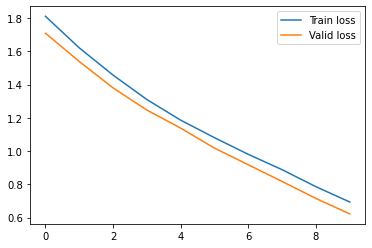

In [57]:
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

#### With Image Augmentation

In [58]:
# Set seed for repetibility
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

LR = 0.000003
NUMBER_EPOCHS = 10

# Define train transform
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

train_loader, valid_loader = get_dataloaders(train_transform, BATCH_SIZE)

inputs, classes = next(iter(train_loader))

resnet18_with_aug = TorchVisionResNet18().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(resnet18_with_aug.parameters(), lr=LR, weight_decay=0.0001)

train_loss, valid_loss = train_model(resnet18_with_aug, train_loader, valid_loader, criterion, optimizer, NUMBER_EPOCHS)

7264 Training images, 1817 Validation images
Training epoch 1 | Loss 1.710796 | Accuracy 28.73% | F1 16.07% | Precision 39.76% | Recall 28.73% | Time 31.39 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation epoch 1 | Loss 1.491340 | Accuracy 38.75% | F1 28.62% | Precision 42.84% | Recall 38.75% | Time 6.45 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training epoch 2 | Loss 1.313053 | Accuracy 49.94% | F1 44.48% | Precision 57.43% | Recall 49.94% | Time 31.82 seconds
Validation epoch 2 | Loss 1.139717 | Accuracy 55.15% | F1 50.42% | Precision 64.22% | Recall 55.15% | Time 6.83 seconds
Training epoch 3 | Loss 1.040950 | Accuracy 68.34% | F1 67.21% | Precision 70.91% | Recall 68.34% | Time 31.52 seconds
Validation epoch 3 | Loss 0.877713 | Accuracy 82.88% | F1 82.92% | Precision 83.69% | Recall 82.88% | Time 6.51 seconds
Training epoch 4 | Loss 0.767024 | Accuracy 83.92% | F1 83.73% | Precision 84.10% | Recall 83.92% | Time 30.82 seconds
Validation epoch 4 | Loss 0.607706 | Accuracy 89.38% | F1 89.40% | Precision 89.55% | Recall 89.38% | Time 6.43 seconds
Training epoch 5 | Loss 0.581806 | Accuracy 87.11% | F1 87.02% | Precision 87.14% | Recall 87.11% | Time 31.23 seconds
Validation epoch 5 | Loss 0.460001 | Accuracy 93.34% | F1 93.36% | Precision 93.40% | Recall 93.34% | Time 6.41 seconds
Training epoch 6 | Loss 0.480664 | Accuracy 

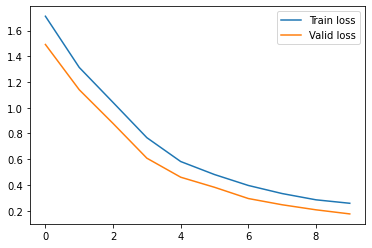

In [60]:
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

In [61]:
torch.save(resnet18_with_aug.state_dict(), 'resnet_checkpoint_sin.pth')

# download checkpoint file
files.download('resnet_checkpoint_sin.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>